# importing libraries

In [2]:
import os
import pandas as pd
os.environ["AICORE_AUTH_URL"] = "https://btp-ai-developments-sl2f9ys4.authentication.eu10.hana.ondemand.com"
os.environ["AICORE_CLIENT_ID"] = "sb-38176009-b499-470f-a3b8-9cf98daac1d0!b503699|aicore!b540"
os.environ["AICORE_CLIENT_SECRET"] = "1ac5c77f-d5ac-4e2d-8c19-6ffc47113ec8$52U4q9NYAN-GBm23a2lm_SFVrzmWNhuS7l_qFXs4s4A="
os.environ["AICORE_BASE_URL"] = "https://api.ai.prod.eu-central-1.aws.ml.hana.ondemand.com"
os.environ["AICORE_RESOURCE_GROUP"]="default"
os.environ["TAVILY_API_KEY"] = "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"

# defining llm

In [3]:
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm_model = init_llm('gpt-4o', max_tokens=10000, temperature = 0)

In [4]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine,inspect,text
from langchain.chains import create_sql_query_chain
from urllib.parse import quote_plus

## configuring database instance
host = "cfe32093-429a-4e59-87dc-9f3e4da891bf.hna2.prod-eu10.hanacloud.ondemand.com"
port = "443"
# schema_name = "INVT_XAI"
schema_name = "CURRENT_INVT"
user = "DBADMIN"
password = "Bcone@1234567"

## Encode user and password
user_enc = quote_plus(user)
password_enc = quote_plus(password)

# Connecting to S4 HANA DB:
connection_str = f"hana://{user_enc}:{password_enc}@{host}:{port}/?currentSchema={schema_name}"
engine = create_engine(connection_str)


In [5]:

def refine_query_with_history(llm, user_query, max_prompt_length=3000):
    """
    Refines the current user query using recent query history to add context.
    """
    # Combine recent queries until reaching the max_prompt_length (character count for simplicity)

    query = text("""
        SELECT * FROM "INVT_XAI_RAW"."QUERY_HISTORY"
        ORDER BY "QueryDateTime" DESC LIMIT 5
    """)
    with engine.connect() as conn:
        result = conn.execute(query)
        recent_queries_df = pd.DataFrame(result.fetchall(), columns=result.keys())

    history_combined = ""
    for i, row in recent_queries_df.iterrows():
        line = f"Previous Query {i+1}: {row['UserQuery']}\n"
        if len(history_combined + line) > max_prompt_length:
            break
        history_combined += line

    prompt = f"""

    Given the user question and chat history.Follow these steps:

    question Analysis: Analyze the user question to determine if it is incomplete or insufficient. If the question lacks necessary details,  add relevant details (such as missing columns, table names, or conditions).

    Follow-Up Handling: If the question seems to depend on the output of a previous question, examine the chat history to identify references to specific entities (such as ID columns or other key data). Modify the follow-up question accordingly, ensuring it correctly references these entities and aligns with the context of the previous interactions.

    Modify the user question ONLY when required.
    Avoid any other additonal text

    Here is the recent query history:
    {history_combined}

    Now, the user has asked:
    {user_query}

    """

    try:
        response = llm.invoke(prompt)
        refined_query = response.content.strip()
        return refined_query
    except Exception as e:
        print(f"Error refining query from history: {e}")
        return user_query


In [6]:
user_query = "What is the reason for the Overstock instance for product FG-100-001 at location DC2000 starting from week 43 2025?"
refined_query = refine_query_with_history(llm_model, user_query, max_prompt_length=3000)
refined_query

'What is the reason for the Overstock instance for product FG-100-001 at location DC2000 starting from week 43 2025, considering the available stock values for these weeks?'

# defining tools for reasoning agent

In [7]:
from langgraph.prebuilt import create_react_agent
from reasoning_agent_pipeline import reasoning_execution_pipeline
from langchain_core.tools import tool

@tool
def reasoning_pipeline_tool(user_input: str) -> dict:
    """Runs the SQL pipeline and returns results."""
    return reasoning_execution_pipeline(user_input)

reasoning_agent = create_react_agent(
    model=llm_model,
    tools=[reasoning_pipeline_tool],
    name="reasoning_agent",
    prompt=(
        "You are an expert Inventory Risk Management Reasoning Agent."
        "Your task is to prvoide the overstock and understock reasons "
    ),
)


In [8]:
from sql_text_conversion import execute_pipeline


@tool
def sql_pipeline_tool(user_input: str) -> dict:
    """Runs the SQL pipeline and returns results."""
    return execute_pipeline(user_input)

sql_agent = create_react_agent(
    model=llm_model,
    tools=[sql_pipeline_tool],
    name="sql_agent",
    prompt=(
        "You are an SQL processing agent. Generate queries, execute via the SQL tool, "
        "and return results. Used for information retrival.Do not perform web lookups."
    ),
)


dict_keys(['COST', 'CUSTOMER_SOURCE', 'DEMAND_FULFILLMENT', 'LOCATION', 'LOCATION_PRODUCT', 'LOCATION_SOURCE', 'PRODUCT', 'PRODUCTION_SOURCE_HEADER', 'PRODUCTION_SOURCE_ITEM', 'PRODUCTION_SOURCE_RESOURCE', 'PROFIT_MARGIN', 'REVIEW_CAPACITY', 'REVIEW_COMPONENT', 'REVIEW_DC', 'REVIEW_PLANT', 'REVIEW_VENDORS', 'STOCK_STATUS', 'STOCK_STATUS_V2'])


In [9]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [10]:
os.environ["TAVILY_API_KEY"] = "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"
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)


In [11]:
research_agent = create_react_agent(
    model = llm_model,
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [12]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=llm_model,
    agents=[reasoning_agent, research_agent,sql_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a reasoning agent. Assign reasoning-related tasks to this agent\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

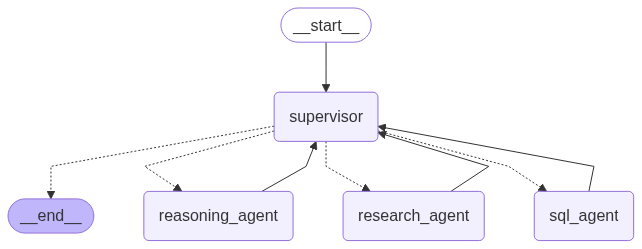

In [13]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [14]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the reason for the Overstock instance for product FG-100-001 at location DC2000 starting from week 43 2025?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_reasoning_agent

Successfully transferred to reasoning_agent


{
    "product_id" : "FG-100-001",
    "location_id": "DC2000",
    "week_num" : 43,
    "year": 2025,
    "week_end_date" :  "Not provided by user"
}
[['FG-100-001', 'PL1000', 'understock_instance_2'], ['FG-100-001', 'RDC1000', 'overstock_instance_2'], ['FG-400-001', 'RDC1000', 'understock_instance_1'], ['FG-100-001', 'DC2000', 'overstock_instance_2'], ['FG-100-001', 'DC1000', 'overstock_instance_1'], ['FG-200-001', 'DC1000', 'overstock_instance_4'], ['SFG-100-001', 'PL2000', 'understock_instance_1'], ['FG-400-001', 'DC2000', 'understock_instance_1'], ['FG-200-001', 'DC1000', 'understock_instance_1'], ['SFG-100-001', 'PL1000', 'understock_instance_1'], ['FG-400-001', 'RDC1000', 'understock_instance_2'], ['FG-200-001', 'DC2000', 'overstock_instance_1'], ['FG-200-001', 'RDC1000', 'understock_insta

In [20]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Mention all the instances or weeks where projected onhand value is greater than 10 percent of safety stock  for Product FG-100-001 and location DC1000",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The research agent was unable to access specific databases or perform calculations related to inventory projections or safety stock levels. You may need to consult your company's inventory management system or database to obtain this information.




In [14]:
response = supervisor.invoke({
    "messages": [
        {"role": "user", "content": "Mention all the instances or weeks where projected onhand value is greater than 10 percent of safety stock  for Product FG-100-001 and location DC1000"}
    ]
})


In [18]:
messages = response.get("messages", [])
final_msg = messages[-1]
final_msg.content

'The research agent needs access to the data or information source to proceed with the task. Could you please provide the necessary data or specify where it can be found?'

In [19]:
messages

[HumanMessage(content='Mention all the instances or weeks where projected onhand value is greater than 10 percent of safety stock  for Product FG-100-001 and location DC1000', additional_kwargs={}, response_metadata={}, id='2bbae99e-cb43-4b31-ba40-556d38ee292b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zGGwOCjxb1bBfzBclsLtNb2p', 'function': {'arguments': '{}', 'name': 'transfer_to_research_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 173, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C4RTcsF4mWkWqjuZBJaVow5ZvGiDw', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='ru

In [16]:
refined_query

'To generate a SQL query that addresses the user\'s request, we need to gather information about the understock instances for product FG-300-001 at location DC1000 during weeks 25 to 28 of the year 2026. The query should identify the reasons for understock, which may involve checking inventory levels, supply chain issues, demand forecasts, or any other relevant factors that could contribute to understock situations.\n\nHere is a complete user query in plain English:\n\n"Generate a SQL query to identify the reasons for understock instances for product FG-300-001 at location DC1000 during weeks 25 to 28 of the year 2026. The query should include information about inventory levels, supply chain disruptions, demand forecasts, and any other relevant factors that could contribute to understock situations. Ensure the query checks for discrepancies between projected and actual stock levels, supply delays, and unexpected demand spikes."'